In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.compat import lzip
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config
import pickle
import warnings

warnings.filterwarnings('ignore')
set_config(display="diagram")

/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Création d'un modèle de machine learning (régression linéaire) afin de prédire l'espérance de vie

### On récupère et on prévisualize nos datasets

In [2]:
df1 = pd.read_csv('Life Expectancy Data.csv')
df2 = pd.read_csv('Life_Expectancy_00_15.csv')

In [3]:
df1.sample(3)

Country  Year      Status  Life expectancy   Adult Mortality  \
166     Bahamas  2009  Developing              74.6            168.0   
198  Bangladesh  2009  Developing              69.5            144.0   
176     Bahrain  2015  Developing              76.9             69.0   

     infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
166              0     9.29                0.000000         95.0         0   
198            135     0.01               53.264004         97.0       718   
176              0      NaN                0.000000         98.0         0   

     ...  Polio  Total expenditure  Diphtheria    HIV/AIDS           GDP  \
166  ...   97.0               7.43         96.0        0.1           NaN   
198  ...   97.0               2.91         97.0        0.1    681.125368   
176  ...   98.0                NaN         98.0        0.1  22688.878240   

     Population   thinness  1-19 years   thinness 5-9 years  \
166         NaN                    2.5                  2.5   
198   1545478.0                   19.1                 19.7   
176         NaN                    6.2                  6.1   

     Income composition of resources  Schooling  
166                            0.791       12.6  
198                            0.523        8.4  
176                            0.823       14.5  

[3 rows x 22 columns]

In [4]:
df2.sample(3)

Country  Year      Continent  Least Developed  Life Expectancy  \
1854     Uruguay  2014  South America            False           77.244   
908   Kazakhstan  2012           Asia            False           69.520   
95     Australia  2015        Oceania            False           82.400   

      Population  CO2 emissions  Health expenditure  \
1854     3400439       1.911518            8.073218   
908     16792090      14.566383            3.037260   
95      23815995      15.863288            9.327589   

      Electric power consumption  Forest area  GDP per capita  \
1854                 3001.384301    10.754542     20093.62407   
908                  4892.734896     1.175201     22032.17454   
95                  10071.398980    17.324825     46248.61646   

      Individuals using the Internet  Military expenditure  \
1854                       61.460000              1.807429   
908                        61.906627              1.046906   
95                         84.560515              1.951028   

      People practicing open defecation  \
1854                           0.659960   
908                            0.030528   
95                             0.000000   

      People using at least basic drinking water services  \
1854                                          98.993558     
908                                           94.338501     
95                                            99.970006     

      Obesity among adults  Beer consumption per capita  
1854                  27.8                         1.94  
908                   18.7                         1.91  
95                    29.8                         3.76

### On merge nos datasets sur les colonnes 'Country' et 'Year' puis on visualize le résultat afin de déterminer leurs différences

In [5]:
df_vis = pd.merge(df1, df2, how='outer', on=['Country','Year'])
df_vis.to_csv('merged_life_expectancy_test.csv')

In [6]:
# Pays de df1 n'ayant de données que pour l'année 2013

df1_2013_only_countries = [
    'Dominica',
    'Cook Islands',
    'Marshall Islands',
    'Monaco',
    'Nauru',
    'Niue',
    'Palau',
    'Saint Kitts and Nevis',
    'San Marino',
    'Tuvalu'
]

In [7]:
# Pays uniquement présents dans df1 (sans compter df1_2013_only_countries qui ne sont pas dans df2 non plus)

df1_only_countries_list = [
    'Afghanistan', 'Antigua and Barbuda', 'Azerbaijan', 'Bahamas', 'Barbados',
    'Belize', 'Bhutan', 'Bosnia and Herzegovina', 'Burkina Faso', 'Burundi',
    'Cabo Verde', 'Central African Republic', 'Chad', 'Comoros', 'Cuba',
    "Democratic People's Republic of Korea", 'Republic of Korea', 'Djibouti',
    'Dominican Republic', 'Equatorial Guinea', 'Fiji', 'Gambia', 'Grenada',
    'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Iceland', 'Japan', 'Kiribati',
    "Lao People's Democratic Republic", 'Lebanon', 'Lesotho', 'Liberia',
    'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Mauritania',
    'Micronesia (Federated States of)', 'Papua New Guinea', 'Rwanda',
    'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa',
    'Sao Tome and Principe', 'Seychelles', 'Sierra Leone', 'Singapore',
    'Solomon Islands', 'Somalia', 'South Sudan', 'Suriname', 'Swaziland',
    'Syrian Arab Republic', 'Timor-Leste', 'Tonga', 'Turkmenistan', 'Uganda',
    'United Arab Emirates', 'Uzbekistan', 'Vanuatu', 'Viet Nam', 'Zambia'
]

In [8]:
# Pays dans df1 et df2 mais dont le nom est différent (la clé correspond au nom dans df1 et l'argument au nom dans df2)

country_names = {
    'Bolivia (Plurinational State of)' : 'Bolivia',
    'Congo' : 'Congo Rep.',
    'Democratic Republic of the Congo' : 'Congo Dem. Rep.',
    "Côte d'Ivoire" : "Cote d'Ivoire",
    'Iran (Islamic Republic of)' : 'Iran',
    'Kyrgyzstan' : 'Kyrgyz Republic',
    'Slovakia' : 'Slovak Republic',
    'United Republic of Tanzania' : 'Tanzania',
    'Turkey' : 'Turkiye',
    'United Kingdom of Great Britain and Northern Ireland' : 'United Kingdom',
    'United States of America' : 'United States',
    'Venezuela (Bolivarian Republic of)' : 'Venezuela',
    'The former Yugoslav republic of Macedonia' : 'North Macedonia',
    'Republic of Moldova' : 'Moldova'
}

### On enlève les pays présents uniquement dans df1 et on standardise les noms puis on merge les dataframes résultants

In [9]:
df1_clean = df1.copy()

df1_clean = df1_clean[~df1_clean['Country'].isin(df1_2013_only_countries+df1_only_countries_list)]
df1_clean['Country'] = df1_clean['Country'].apply(lambda name: country_names[name] if name in country_names else name)

In [10]:
df = pd.merge(df1_clean, df2, how='outer', on=['Country','Year'])
df.sample(3)

Country  Year      Status  Life expectancy   Adult Mortality  \
1167     Myanmar  2000  Developing              62.1            243.0   
1028    Malaysia  2011  Developing              74.3             13.0   
1137  Mozambique  2014  Developing              56.7            375.0   

      infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
1167             73     0.35                2.511437          NaN       845   
1028              3     0.51                9.230026         96.0      1569   
1137             61     0.01               54.911595         79.0         9   

      ...  Health expenditure  Electric power consumption  Forest area  \
1167  ...            1.995493                   68.101490    53.352679   
1028  ...            3.314519                 4145.521977    57.984976   
1137  ...            6.332318                  451.043068    48.508899   

      GDP per capita  Individuals using the Internet  Military expenditure  \
1167      824.962767                        0.000168              2.001199   
1028    21704.744270                       61.000000              1.552853   
1137     1139.051782                        6.000000              0.980759   

      People practicing open defecation  \
1167                          10.111872   
1028                           0.374551   
1137                          32.294620   

      People using at least basic drinking water services  \
1167                                          46.975984     
1028                                          97.023887     
1137                                          48.825319     

      Obesity among adults  Beer consumption per capita  
1167                   1.9                      0.10454  
1028                  12.1                      0.39000  
1137                   5.5                      0.84000  

[3 rows x 37 columns]

In [11]:
df.to_csv('merged_life_expectancy.csv')

### On regarde le taux de remplissage de chaque colonne

In [12]:
def set_color(x):
    if type(x) == str: return 'color: black'
    if x == 100: return 'color: green'
    if x > 89: return 'color: orange'
    return 'color: red'

In [13]:
pd.set_option('display.min_rows', 20)
tdf = (df.count()/df.shape[0]*100).astype(int).to_frame().rename({0 : 'Remplissage (%)'}, axis=1)
tdf_vis = pd.DataFrame({
    'Colonnes (1-19)' : tdf.head(19).index,
    '(%)' : tdf['Remplissage (%)'].head(19).values.tolist(),
    ' ' : [' ']*19,
    '|' : ['|']*19,
    'Colonnes (20-37)' : tdf.tail(18).index.tolist()+[' '],
    '(%) ' : tdf['Remplissage (%)'].tail(18).values.tolist()+[' ']})

In [14]:
tdf_vis.style.hide_index().applymap(lambda x: set_color(x))

### On compare la distribution des espérances de vie selon df1 et df2

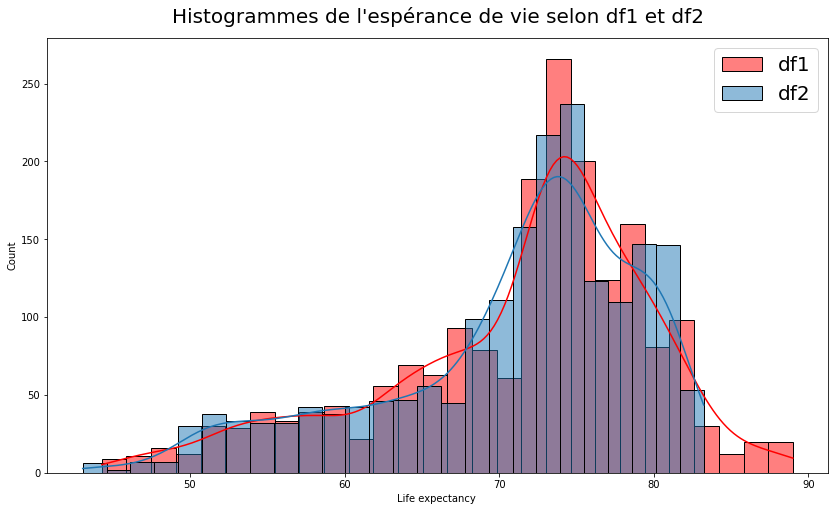

In [15]:
plt.figure(figsize=(14,8))
sns.histplot(df['Life expectancy '], kde=True, color='r', label='df1')
sns.histplot(df['Life Expectancy'], kde=True, label='df2')
plt.title("Histogrammes de l'espérance de vie selon df1 et df2", fontsize=20, pad=15)
plt.legend(fontsize=20);

#### La distribution de l'espérance de vie de df2 semble plus cohérente, c'est donc celle-là que l'on va utiliser.

In [16]:
df.drop(columns='Life expectancy ', inplace=True)
y = df['Life Expectancy']

### On visualize les corrélations entre chaques colonnes dans une heatmap afin de faire un pré-sélection des potentielles features

In [17]:
df_hm = pd.concat([pd.get_dummies(df.drop(columns=['Country', 'Year', 'Life Expectancy'])), df[['Life Expectancy']]], axis=1)
corr = df_hm.corr()

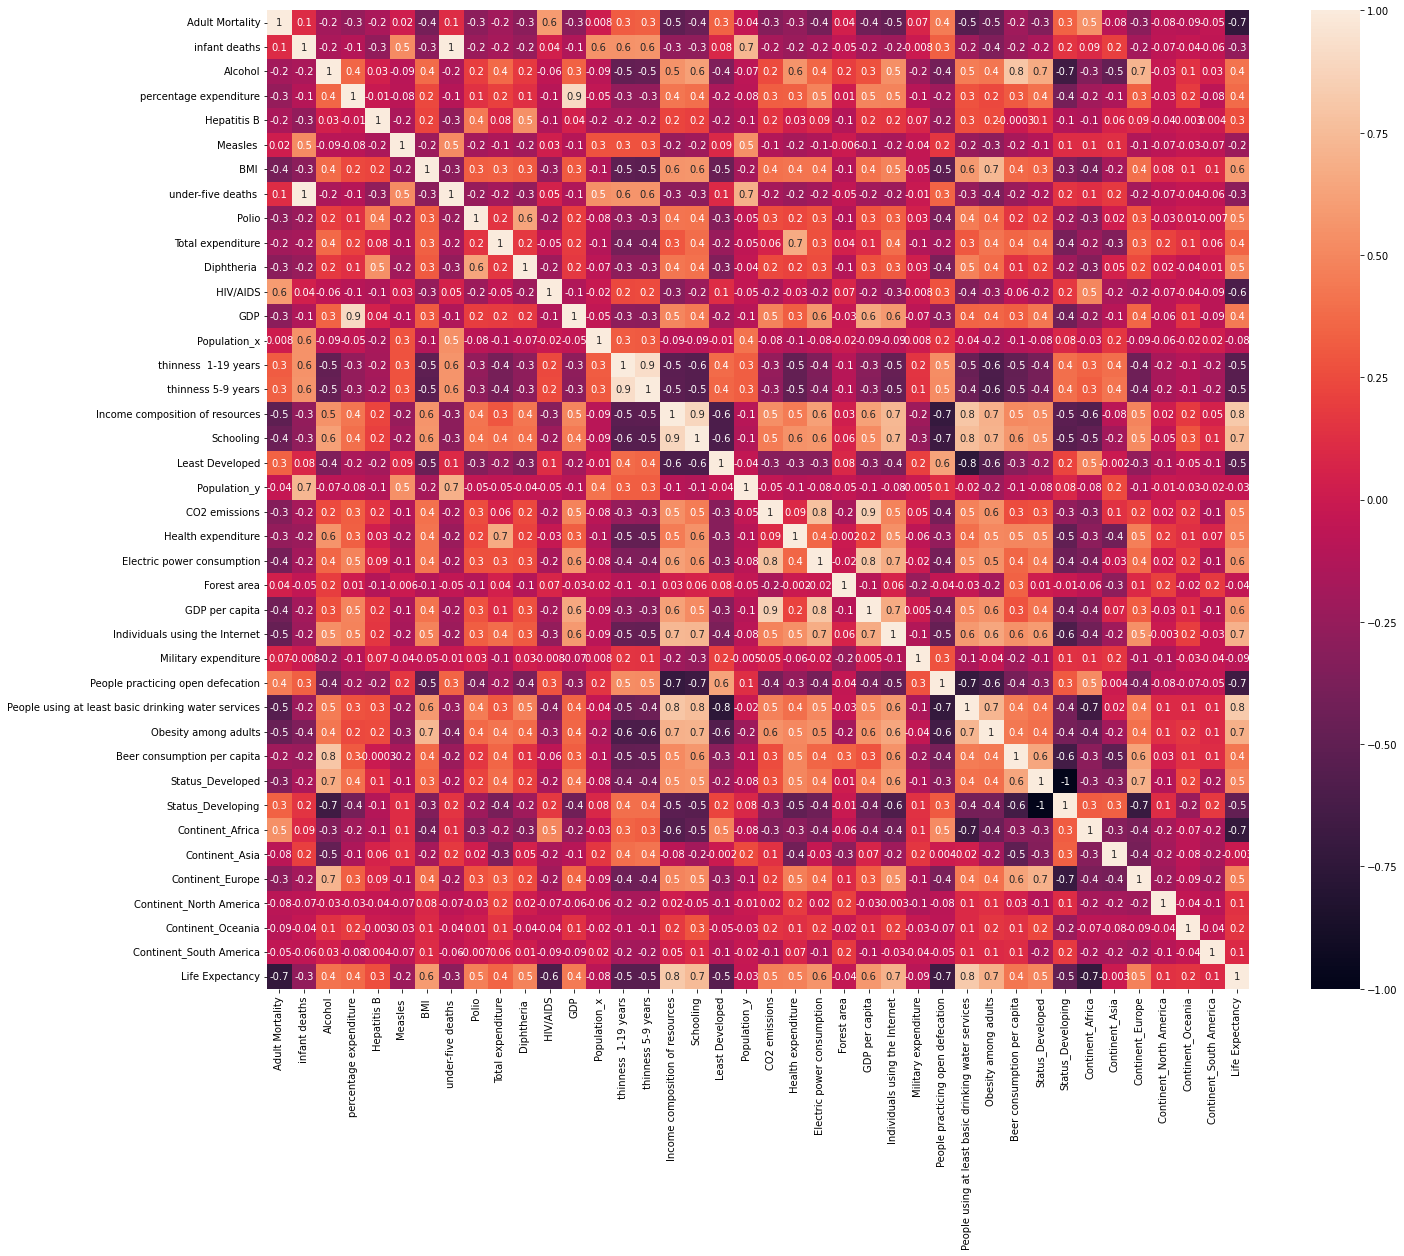

In [18]:
plt.figure(figsize=(22,18))
sns.heatmap(corr, annot=True, fmt='0.1g');

In [19]:
potential_features = [                                      # | Score | Commentaire sur la pertinence     | Gardé |
                                                            # |_______|___________________________________|_______|
    'People using at least basic drinking water services',  # |  0.82 |                                   |  Oui  |
    'Income composition of resources',                      # |  0.81 |                                   |  Oui  |
    'Schooling',                                            # |  0.75 |                                   |  Oui  |
    'Adult Mortality',                                      # | -0.73 | Valeurs aberrantes                |  Non  |
    'Continent_Africa',                                     # | -0.73 | Feature immuable                  |  Non  |
    'Individuals using the Internet',                       # |  0.70 | Corrélation mais pas de causalité |  Non  |
    'Obesity among adults',                                 # |  0.69 | Corrélation mais pas de causalité |  Non  |
    'People practicing open defecation',                    # | -0.67 | Trop spécifique ?                 |  Non  |
    ' HIV/AIDS',                                            # | -0.60 |                                   |  Oui  |
    ' BMI ',                                                # |  0.59 | Corrélation mais pas de causalité |  Non  |
    'GDP per capita',                                       # |  0.58 |                                   |  Oui  |
    'Electric power consumption',                           # |  0.56 | Corrélation mais pas de causalité |  Non  |
    'Least Developed',                                      # | -0.55 | A définir                         |  Non  |
    ' thinness 5-9 years',                                  # | -0.54 |                                   |  Oui  |
    'Status_Developed',                                     # |  0.49 |                                   |  Oui  |
    'Continent_Europe',                                     # |  0.48 | Feature immuable                  |  Non  |
    'Diphtheria ',                                          # |  0.48 | Valeurs aberrantes                |  Non  |
    'Health expenditure',                                   # |  0.47 |                                   |  Oui  |
    'Polio',                                                # |  0.47 | Valeurs aberrantes                |  Non  |
    'CO2 emissions',                                        # |  0.46 | Corrélation mais pas de causalité |  Non  |
    'GDP',                                                  # |  0.44 |                                   |  Oui  |
    'Beer consumption per capita',                          # |  0.42 | Corrélation mais pas de causalité |  Non  |
    'Alcohol',                                              # |  0.41 | Corrélation mais pas de causalité |  Non  |
    'percentage expenditure'                                # |  0.38 | A définir                         |  Non  |
                                                            # |_______|___________________________________|_______|
]

In [20]:
features_gardées = [
    'People using at least basic drinking water services',
    'Income composition of resources',
    'Schooling',
    ' HIV/AIDS',
    'GDP per capita',
    ' thinness 5-9 years',
    'Status_Developed',
    'Health expenditure',
    'GDP'
]

In [21]:
df_clean = df[list(set(['Life Expectancy']+features_gardées)-{'Status_Developed'})].applymap(lambda x: x if x else np.NaN)
df_clean['Status_Developed'] = df['Status'].apply(lambda x: 1 if x == 'Developed' else 0)
df_clean.sample(3)

Schooling   HIV/AIDS  GDP per capita  Health expenditure  \
119        14.4        0.1     47893.28238            3.285104   
1108       15.1        0.1     14472.48482            7.966922   
1217       19.2        0.1     37293.35679            9.401684   

      Life Expectancy   thinness 5-9 years  Income composition of resources  \
119         75.770000                  5.9                            0.815   
1108        75.982927                  2.0                            0.792   
1217        81.404878                  0.3                            0.910   

      People using at least basic drinking water services          GDP  \
119                                           99.969586    2367.565350   
1108                                          96.409098    7318.742449   
1217                                         100.000003    4453.246730   

      Status_Developed  
119                  0  
1108                 0  
1217                 1

In [22]:
fontlabel = {'fontsize': '12',
             'fontweight': 'bold',
             'color': "black"}

fonttitle = {'fontsize': '15',
             'fontweight': 'bold',
             'color': "black"}

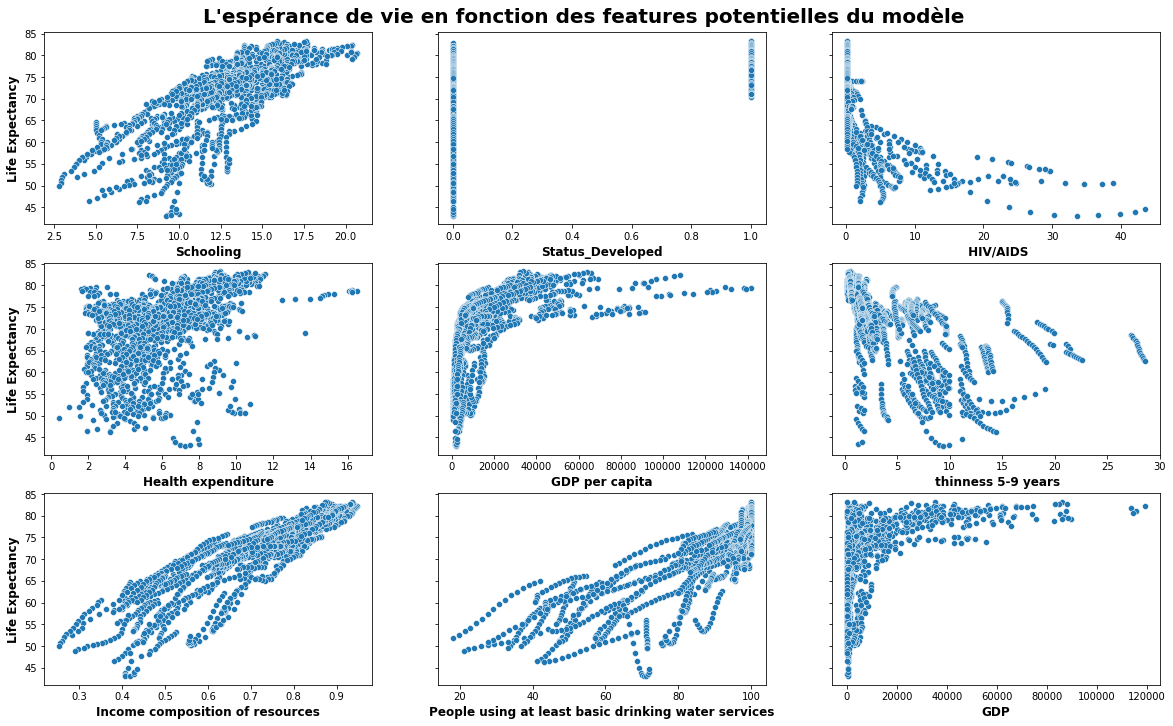

In [23]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(figsize=(20,12),nrows=3, ncols=3, sharey=True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
for i, column in enumerate(df_clean[list(set(df_clean.columns.values)-{'Life Expectancy'})].columns.values.tolist()):
    sns.scatterplot(df_clean[column], df['Life Expectancy'], ax=axes[i])
    axes[i].set_xlabel(column, fontdict=fontlabel)
    axes[i].set_ylabel('Life Expectancy', fontdict=fontlabel)
fig.suptitle("L'espérance de vie en fonction des features potentielles du modèle", size=20, weight='bold', y=0.91);

### On créé une classe et ses méthodes pour simplifier la création de modèles et le test des features potentielles 

In [24]:
class ModeleLineaire():
    
    def __init__(self, X, y, 
                 num_imputer=SimpleImputer(strategy='median'), 
                 num_transformer=MinMaxScaler(), 
                 cat_transformer=OneHotEncoder(handle_unknown='ignore', drop='first'),
                 test_size=0.3):
        
        self.X = X
        self.y = y              
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size)

        num_cols = X._get_numeric_data().columns.values.tolist()
        cat_cols = list(set(X.columns)-set(X._get_numeric_data().columns))
        
        num_pipeline = Pipeline([
            ('imputer', num_imputer),
            ('scaler', num_transformer)])
        
        self.preprocessor = ColumnTransformer([
            ('num_transformer', num_pipeline, num_cols),
            ('cat_transformer', cat_transformer, cat_cols)])
        
        self.pipeline = make_pipeline(self.preprocessor, LinearRegression())
    
        self.pipe = self.pipeline.fit(self.X_train, self.y_train)

    def show_scores(self, cv=5, scoring='r2'):
        for i, r2 in enumerate(cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring=scoring)):
            (R2 := np.array(r2))
            print(f' {i+1}. r2 = {round(r2,2)}')
        print('Moyenne des r2 :', round(R2.mean(),2))
        print('Score du test :', round(self.pipe.score(self.X_test, self.y_test),2))
    
    def finalize(self): return self.pipeline.fit(self.X, self.y)
    
    def tts(self): return self.X_train, self.X_test, self.y_train, self.y_test

    def prediction(self, X=0): 
        if type(X) == int: return self.pipe.predict(self.X_test)
        return self.pipe.predict(X)
    
    def residuals(self): return self.prediction() - self.y_test
    
    def het(self): return sms.het_breuschpagan(self.residuals(), self.preprocessor.fit_transform(self.X_test))
    
    def plot(self):
        
        def test_homo():
            names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
            test = self.het()
            p_value = lzip(names, test)[1][1]
            if p_value > 0.05: return f"p-value = {round(p_value,2)} > 0.05 :\nNous ne pouvons pas rejeter l'hypothèse nulle.\nC'est homoscédastique"
            return f"p-value = {round(p_value,2)} <= 0.05 :\nNous pouvons rejeter l'hyptohèse nulle.\nC'est hétéroscédastique"

        def remove_spine(axe):
            axe.spines.right.set_visible(False)
            axe.spines.top.set_visible(False)
        
        residus = self.residuals()
        
        fontdict = {'fontsize': '16',
                    'fontweight': 'bold',
                    'color': "black"}

        fig, ((ax1,ax2),
              (ax3,ax4)) = plt.subplots(figsize=(15, 10),nrows=2, ncols=2)

        ax1.set_title('Condition de normalité des erreurs', fontdict)
        sns.histplot(residus, ax = ax1, kde = True)
        ax1.set_xlabel('Résidus')
        remove_spine(ax1)

        ax2.set_title("Visualisation de l'homoscedasticité", fontdict)
        ax2.scatter(self.y_test, residus, c="red")
        ax2.plot(np.array(range(40,90)),np.zeros(50), c="black")
        ax2.set_xlabel('y observé')
        ax2.set_ylabel('Résidus')
        remove_spine(ax2)

        sentence = test_homo()
        ax2.annotate(sentence,ha='left',fontsize=10,fontstyle='italic', xy=(75, 4),
                     xytext=(65, 9),color='black',fontweight="extra bold", bbox=dict(color="white"),
                     arrowprops=dict(color="#1d2d35",linewidth="2",arrowstyle="->", connectionstyle="angle3"))

        ax3.set_title('QQ plot', fontdict)
        sm.qqplot(residus, line='s', ax= ax3)
        remove_spine(ax3)

        ax4.set_visible(False)

        plt.show()

### On créé un modèle à partir d'une première feature *(People using at least basic drinking water services)*

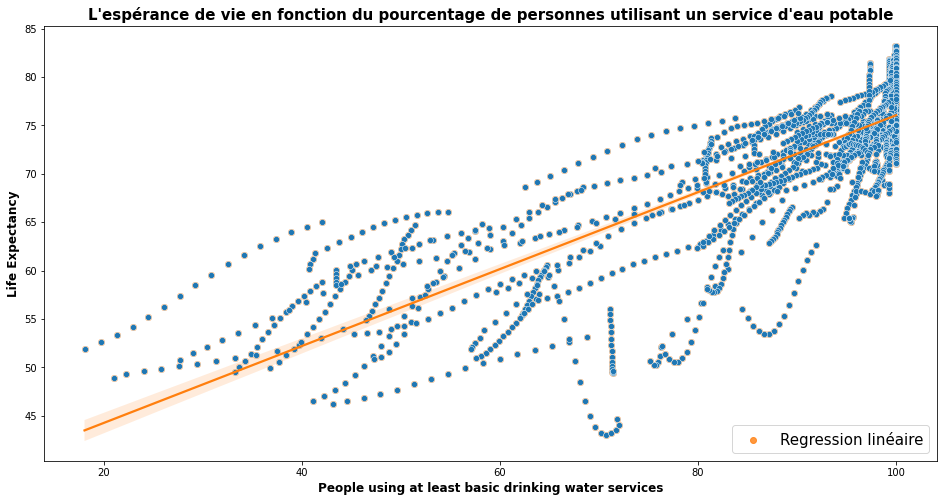

In [25]:
plt.figure(figsize=(16,8))
sns.regplot(df['People using at least basic drinking water services'], y, color='C1', label='Regression linéaire')
sns.scatterplot(df['People using at least basic drinking water services'], y)
plt.xlabel('People using at least basic drinking water services', fontdict=fontlabel)
plt.ylabel('Life Expectancy', fontdict=fontlabel)
plt.legend(fontsize=15, loc='lower right')
plt.title("L'espérance de vie en fonction du pourcentage de personnes utilisant un service d'eau potable", fontdict=fonttitle);

In [26]:
X1 = df_clean[['People using at least basic drinking water services']]

In [27]:
model1 = ModeleLineaire(X1, y)
model1.show_scores()

 1. r2 = 0.66
 2. r2 = 0.65
 3. r2 = 0.68
 4. r2 = 0.71
 5. r2 = 0.68
Moyenne des r2 : 0.68
Score du test : 0.67


### On ajoute une deuxième feature *(Income composition of resources)*

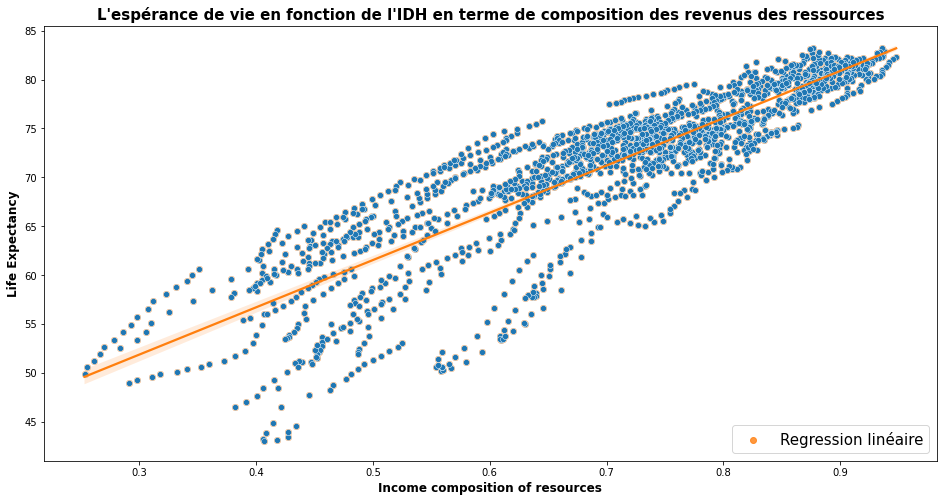

In [28]:
feature2 = df_clean['Income composition of resources']

plt.figure(figsize=(16,8))
sns.regplot(feature2, y, color='C1', label='Regression linéaire')
sns.scatterplot(feature2, y)
plt.xlabel('Income composition of resources', fontdict=fontlabel)
plt.ylabel('Life Expectancy', fontdict=fontlabel)
plt.legend(fontsize=15, loc='lower right')
plt.title("L'espérance de vie en fonction de l'IDH en terme de composition des revenus des ressources", fontdict=fonttitle);

In [29]:
X2 = pd.concat([X1, feature2], axis=1)

In [30]:
model2 = ModeleLineaire(X2, y)
model2.show_scores()

 1. r2 = 0.76
 2. r2 = 0.76
 3. r2 = 0.71
 4. r2 = 0.77
 5. r2 = 0.71
Moyenne des r2 : 0.71
Score du test : 0.76


#### On observe une amélioration signiticative du score de notre modèle, on peut probablement garder cette feature.

In [31]:
fig = px.scatter_3d(pd.concat([X2, y], axis=1), 
                    x='People using at least basic drinking water services', 
                    y='Income composition of resources', 
                    z='Life Expectancy',
                    color='Life Expectancy',
                    title="L'espérance de vie en fonction des deux premières features",
                    color_continuous_scale=px.colors.diverging.BrBG,
                    opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=60))

### On ajoute une troisième feature à notre modèle *(Schooling)*

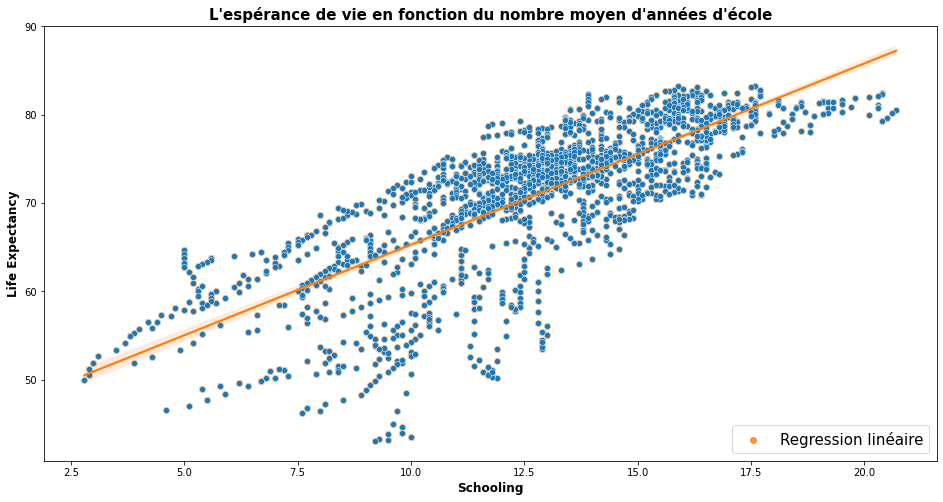

In [32]:
feature3 = df_clean['Schooling']

plt.figure(figsize=(16,8))
sns.regplot(feature3, y, color='C1', label='Regression linéaire')
sns.scatterplot(feature3, y)
plt.xlabel('Schooling', fontdict=fontlabel)
plt.ylabel('Life Expectancy', fontdict=fontlabel)
plt.legend(fontsize=15, loc='lower right')
plt.title("L'espérance de vie en fonction du nombre moyen d'années d'école", fontdict=fonttitle);

In [33]:
X3 = pd.concat([X2, feature3], axis=1)

In [34]:
model3 = ModeleLineaire(X3, y)
model3.show_scores()

 1. r2 = 0.76
 2. r2 = 0.75
 3. r2 = 0.72
 4. r2 = 0.72
 5. r2 = 0.81
Moyenne des r2 : 0.81
Score du test : 0.74


#### Pas d'amélioration significative du score du modèle, la feature 'Schooling' est très corrélée aux deux autres, on peut l'enlever de notre modèle.

### On essaie une autre troisième feature *(GDP per capita)*

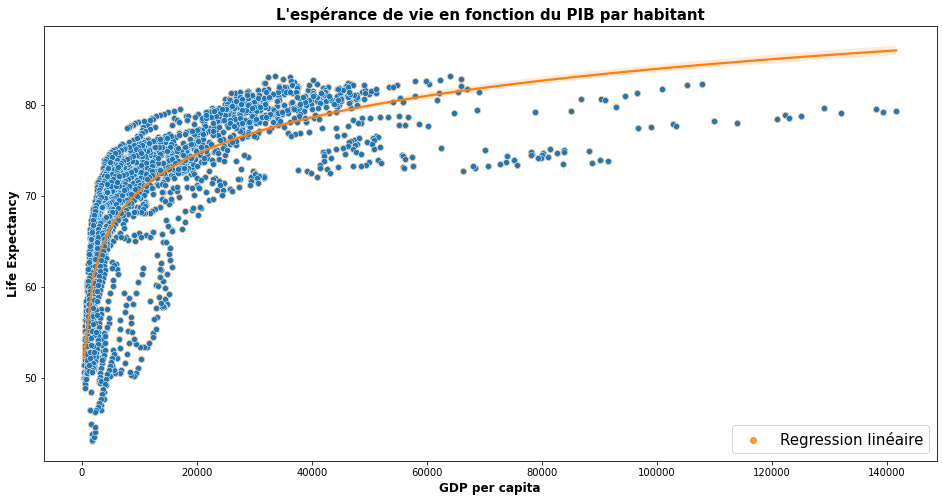

In [35]:
feature4 = df_clean['GDP per capita']

plt.figure(figsize=(16,8))
sns.regplot(feature4, y, color='C1', logx=True, label='Regression linéaire')
sns.scatterplot(feature4, y)
plt.xlabel('GDP per capita', fontdict=fontlabel)
plt.ylabel('Life Expectancy', fontdict=fontlabel)
plt.legend(fontsize=15, loc='lower right')
plt.title("L'espérance de vie en fonction du PIB par habitant", fontdict=fonttitle);

In [36]:
X4 = pd.concat([X2, feature4.apply(lambda x: np.log(x))], axis=1)

In [37]:
model4 = ModeleLineaire(X4, y)
model4.show_scores()

 1. r2 = 0.72
 2. r2 = 0.74
 3. r2 = 0.74
 4. r2 = 0.78
 5. r2 = 0.76
Moyenne des r2 : 0.76
Score du test : 0.76


#### Pas d'amélioration significative du score du modèle, la feature 'GDP per capita' est très corrélée aux deux autres, on peut l'enlever de notre modèle.

### On essaie une autre troisième feature *(HIV/AIDS)*

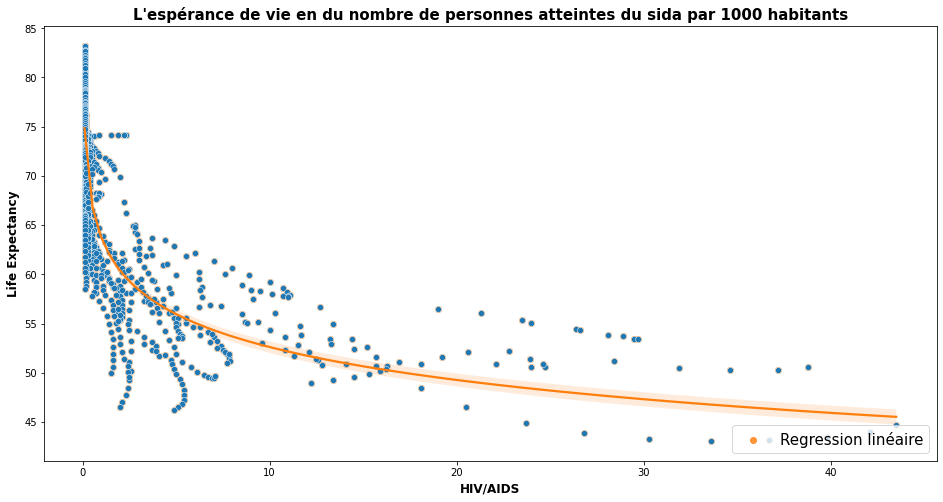

In [38]:
feature5 = df_clean[' HIV/AIDS']

plt.figure(figsize=(16,8))
sns.regplot(feature5, y, color='C1', logx=True, label='Regression linéaire')
sns.scatterplot(feature5, y)
plt.xlabel('HIV/AIDS', fontdict=fontlabel)
plt.ylabel('Life Expectancy', fontdict=fontlabel)
plt.legend(fontsize=15, loc='lower right')
plt.title("L'espérance de vie en du nombre de personnes atteintes du sida par 1000 habitants", fontdict=fonttitle);

In [39]:
X5 = pd.concat([X2, feature5.apply(lambda x: np.log(x))], axis=1).rename({' HIV/AIDS':'HIV/AIDS'}, axis=1)

In [40]:
model5 = ModeleLineaire(X5, y)
model5.show_scores()

 1. r2 = 0.86
 2. r2 = 0.88
 3. r2 = 0.87
 4. r2 = 0.86
 5. r2 = 0.85
Moyenne des r2 : 0.85
Score du test : 0.87


#### On observe une amélioration signiticative du score de notre modèle, on peut probablement garder cette feature.

In [41]:
fig = px.scatter_3d(pd.concat([X5, y], axis=1), 
                    x='People using at least basic drinking water services',
                    y='HIV/AIDS',
                    z='Life Expectancy',
                    color='Income composition of resources',
                    title="L'espérance de vie en fonction des trois premières features",
                    color_continuous_scale=px.colors.diverging.BrBG,
                    opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=60))

#### Les autres features potentielles ont été testées et n'améliorent pas le modèle. Le modèle final est donc model5.

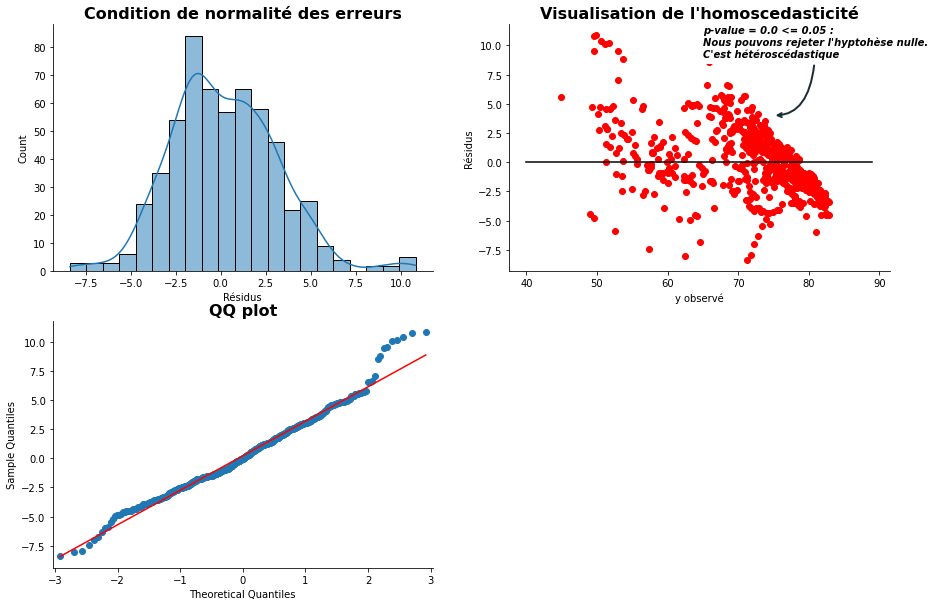

In [42]:
model5.plot()

#### On "pickle" le modèle final afin de pouvoir l'intégrer dans une API

In [43]:
final_model = model5.finalize()

In [44]:
pickle.dump(final_model, open('life_expectancy_model.pkl', 'wb'))

In [45]:
from typing import Union
from fastapi import FastAPI
from pandas import DataFrame
from numpy import log
from pickle import Unpickler

app = FastAPI()

pickled_model = Unpickler(open('life_expectancy_model.pkl', 'rb')).load()


@app.get("/")
def read_root(drink: Union[float, None] = None,
              income: Union[float, None] = None,
              hiv: Union[float, None] = None):

    X = DataFrame({'People using at least basic drinking water services' : [drink],
                   'Income composition of resources' : [income],
                   'HIV/AIDS' : [log(hiv)]})

    pred = pickled_model.predict(X)[0]

    return {'prediction' : round(pred)}
